# Parse {year,type,county} subtotals from NJSP PDFs

NJSP pages for each year (example: [2023](https://www.nj.gov/njsp/info/fatalacc/2023-stats.shtml)) include links to two PDFs:
- Year to Date Comparative ([example](https://www.nj.gov/njsp/info/fatalacc/pdf/swfcs2_23.pdf))
- Victim Classification by County ([example](https://www.nj.gov/njsp/info/fatalacc/pdf/ptccr_23.pdf))

These provide some info that's not available elsewhere:
- {year, victim type, county} subtotals
- {year, victim type, age range} subtotals

These are available for all but 4 years since 2008 (the earliest NJSP data): 2008, 2009, 2017, and 2018. Later in this notebook we recover {year,type} subtotals (sans "county" facet) for those years.

NJSP's per-crash records (`data/FAUQStats*.xml` files) only include "victim type" info since 2020, so this notebook backfills {year,type} subtotals for 2008-2019. It produces `data/year_types.csv`, which `njsp-plots.ipynb` uses as part of a daily Github Action.

In [1]:
from utz import *
from tabula import read_pdf
from nj_crashes.paths import DATA_DIR

Tabula template JSONs and NJSP summary PDFs live in this dir

In [2]:
stats_dir = f'{DATA_DIR}/stats'

Tabula helpers

In [3]:
def load_rects(tpl_name):
    tpl_path = f'{stats_dir}/{tpl_name}.json'
    with open(tpl_path, 'r') as f:
        tpl = json.load(f)
    return tpl

def load_pdf_tbl(rect, pdf_path):
    [tbl] = read_pdf(pdf_path, area=[ rect[k] for k in [ 'y1', 'x1', 'y2', 'x2', ] ], pages='all',)
    return tbl

## Load "Victim Classification by County" data

In [4]:
[ptccr_rect] = load_rects('ptccr_23.tabula-template')
def load_ptccr(year):
    pdf_path = f'{stats_dir}/ptccr_%02d.pdf' % (year % 100)
    tbl = load_pdf_tbl(ptccr_rect, pdf_path)
    tbl['year'] = year
    tbl = tbl.set_index('County')
    return tbl

In [5]:
cur_year = now().year
cur_year

2024

In [6]:
%%time
start_year = 2008
missing_years = [ 2008, 2009, 2017, 2018 ]
summaries = pd.concat([
    load_ptccr(year)
    for year in range(start_year, cur_year)
    if year not in missing_years
])
summaries.columns = summaries.columns.str.lower()
summaries = summaries.rename(columns={
    'pedalcyclist': 'cyclist',
})
summaries.index.name = 'county'
summaries.reset_index().set_index(['year', 'county'])
summaries

CPU times: user 26 ms, sys: 34.6 ms, total: 60.6 ms
Wall time: 8.72 s


,driver,passenger,cyclist,pedestrian,fatalities,crashes,year
county,,,,,,,
Atlantic,10,7,1,6,24,22,2010
Bergen,17,5,0,15,37,36,2010
Burlington,22,7,0,5,34,33,2010
Camden,17,11,3,10,41,37,2010
Cape May,4,1,0,0,5,4,2010
...,...,...,...,...,...,...,...
Somerset,14,4,0,6,24,22,2023
Sussex,6,2,0,1,9,6,2023
Union,13,6,2,15,36,34,2023


## Compare to per-crash records
NJSP's per-crash datasets include victim-type info for crashes since 2020.

This allows for a sanity-check of the {year,type,county} totals reported in the "Victim Classification by County" PDFs (for 2020-2023):

In [7]:
sp = read_parquet(f'{DATA_DIR}/crashes.pqt')
sp

,CCODE,CNAME,MCODE,MNAME,HIGHWAY,LOCATION,FATALITIES,INJURIES,STREET,FATAL_D,FATAL_P,FATAL_T,FATAL_B,dt
ACCID,,,,,,,,,,,,,,
1703,01,Atlantic,0102,Atlantic City,446,State/Interstate Authority 446 S MP 1,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 00:35:00
1681,09,Hudson,0910,Union City,None,Bergenline Ave S MP 0 at 6th St,1.0,NaN,Bergenline Ave,NaN,NaN,NaN,NaN,2008-01-01 04:11:00
1659,04,Camden,0415,Gloucester Twsp,42,State Highway 42 N MP 8.2,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 06:46:00
1661,20,Union,2004,Elizabeth City,624,County 624 W MP 2.2 at Ikea Dr,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 12:29:00
1811,07,Essex,0716,Nutley Town,648,County 648 E MP .87 at Franklin Ave,1.0,NaN,None,NaN,NaN,NaN,NaN,2008-01-01 18:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12929,12,Middlesex,1205,Edison Twsp,1,State Highway 1,1.0,NaN,None,0.0,0.0,1.0,0.0,2024-01-08 02:20:00
12934,15,Ocean,1514,Lakewood Twsp,623,County 623,1.0,NaN,None,0.0,0.0,1.0,0.0,2024-01-08 17:34:00
12937,13,Monmouth,1316,Freehold Twsp,9,State Highway 9,1.0,NaN,None,0.0,0.0,1.0,0.0,2024-01-09 17:35:00


In [8]:
cols = [ 'FATALITIES', 'STREET', 'FATAL_D', 'FATAL_P', 'FATAL_T', 'FATAL_B', ]
y = sp.dt.dt.year.rename('year')
c = sp.CNAME.rename('county')
gb = sp.groupby([y, c])
agg = gb[cols].sum(numeric_only=True).astype(int)
agg['crashes'] = gb.size()
agg = agg.rename(columns={
    'FATALITIES': 'fatalities',
    'FATAL_D': 'driver',
    'FATAL_P': 'passenger',
    'FATAL_T': 'pedestrian',
    'FATAL_B': 'cyclist',
})
agg

fatalities  driver  passenger  pedestrian  cyclist  crashes
year county                                                                 
2008 Atlantic            31       0          0           0        0       30
     Bergen              23       0          0           0        0       22
     Burlington          45       0          0           0        0       45
     Camden              44       0          0           0        0       42
     Cape May            11       0          0           0        0       11
...                     ...     ...        ...         ...      ...      ...
2024 Mercer               1       1          0           0        0        1
     Middlesex            2       0          0           2        0        2
     Monmouth             2       0          1           1        0        2
     Ocean                2       0          0           2        0        2
     Union                1       0          0           1        0        1

[343 rows x 6 columns]

In [9]:
cols = agg.columns.sort_values().tolist()
cols

['crashes', 'cyclist', 'driver', 'fatalities', 'passenger', 'pedestrian']

### Combine aggregate stats from per-crash records vs. stats from PDFs

In [10]:
m = agg.reset_index()
m = m[m.year >= 2020]  # types missing before 2020, in the per-record NJSP data
m = m.merge(summaries.reset_index(), how='left', on=['year', 'county'], suffixes=['_sp', '_stats']).dropna()
m = m.set_index(['year', 'county'])
m = m[m.columns.sort_values()].astype(int)
m.columns = pd.MultiIndex.from_tuples([ tuple(reversed(col.split('_'))) for col in m.columns ])
m = m[m.columns.sort_values()].astype(int)
m

sp                                                 \
                crashes cyclist driver fatalities passenger pedestrian   
year county                                                              
2020 Atlantic        38       0     26         40         5          9   
     Bergen          38       0     14         43         9         20   
     Burlington      40       3     26         42         4          9   
     Camden          36       1     19         38         5         13   
     Cape May         8       1      5          9         0          3   
     Cumberland      22       0     14         24         5          5   
     Essex           39       3     16         45        12         14   
     Gloucester      33       2     21         35         5          7   
     Hudson          24       1     11         24         1         11   
     Hunterdon       12       0      7         12         2          3   
     Mercer          20       0      9         21         5          7   
     Middlesex       61       5     27         67        12         23   
     Monmouth        33       0     23         34         2          9   
     Morris          17       1      8         17         2          6   
     Ocean           30       1     20         30         5          4   
     Passaic         26       0     17         29         5          7   
     Salem           11       0      6         14         5          3   
     Somerset        14       0      7         14         0          7   
     Sussex           7       0      6          7         0          1   
     Union           29       0     13         30         1         16   
     Warren          12       0      9         12         1          2   
2021 Atlantic        46       2     22         49         6         19   
     Bergen          35       0     20         35         2         13   
     Burlington      40       2     24         41         4         11   
     Camden          67       2     30         69         2         35   
     Cape May        12       3      4         12         3          2   
     Cumberland      27       2     17         28         2          7   
     Essex           60       3     22         61         5         31   
     Gloucester      42       1     28         48        10          9   
     Hudson          29       3     11         30         3         13   
     Hunterdon        9       0      9          9         0          0   
     Mercer          35       2     16         38         8         12   
     Middlesex       45       1     26         47         8         12   
     Monmouth        32       1     18         34         4         11   
     Morris          25       1     15         25         5          4   
     Ocean           43       0     26         44         9          9   
     Passaic         24       1     12         25         4          8   
     Salem           20       0     19         22         2          1   
     Somerset        25       0     21         25         1          3   
     Sussex          11       1      7         11         0          3   
     Union           27       1     11         29         6         11   
     Warren          13       0     10         15         2          3   
2022 Atlantic        34       2     18         34         3         11   
     Bergen          38       0     21         44        10         13   
     Burlington      54       1     34         60        12         13   
     Camden          51       1     22         54         5         26   
     Cape May        14       1      5         15         1          8   
     Cumberland      20       0     15         20         1          4   
     Essex           50       0     26         56         9         21   
     Gloucester      39       0     28         40         5          7   
     Hudson          15       0      9         17         2          6   
     Hunterdon        8  

In [11]:
row_diffs = (m['sp'] == m['stats']).all(1)
row_diffs = row_diffs[~row_diffs]
row_diffs

Series([], dtype: bool)

In [12]:
assert row_diffs.all(), row_diffs

## Recovering {year,type} totals for 2008-2009, 2017-2018
Both PDF types are missing for 2008-2009 and 2017-2018, e.g.:
- www.nj.gov/njsp/info/fatalacc/pdf/ptccr_08.pdf
- www.nj.gov/njsp/info/fatalacc/pdf/ptccr_09.pdf
- www.nj.gov/njsp/info/fatalacc/pdf/ptccr_17.pdf
- www.nj.gov/njsp/info/fatalacc/pdf/ptccr_18.pdf

However, "Year to Date Comparative" PDFs, while also missing for those years, typically include {year,type} totals (without a "county" facet) for a given year as well as the two prior.

This allows us to recover {year,type} totals for 2008-2009 (from [the 2010 PDF](www.nj.gov/njsp/info/fatalacc/pdf/swfcs2_10.pdf)) and 2017-2018 (from [the 2019 PDF](www.nj.gov/njsp/info/fatalacc/pdf/swfcs2_19.pdf)):

In [13]:
swfcs_rects = load_rects('swfcs2_23.tabula-template')
swfcs_rects

[{'page': 1,
  'extraction_method': 'guess',
  'x1': 134.64000000000001,
  'x2': 478.89,
  'y1': 323.2125,
  'y2': 435.6675,
  'width': 344.25,
  'height': 112.455},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 63.495000000000005,
  'x2': 550.8,
  'y1': 471.6225,
  'y2': 681.9975000000001,
  'width': 487.305,
  'height': 210.375},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 142.29,
  'x2': 296.82,
  'y1': 105.1875,
  'y2': 196.2225,
  'width': 154.53,
  'height': 91.035}]

In [14]:
def load_swfcs(year):
    pdf_path = f'{stats_dir}/swfcs2_%02d.pdf' % (year % 100)
    [ types, ages, nums, ] = [ load_pdf_tbl(r, pdf_path) for r in swfcs_rects ]
    types = types.rename(columns={'Unnamed: 0': 'type'})
    types['type'] = types['type'].str.lower()
    types = types.set_index('type')
    types = types.rename(index={'pedalcyclist': 'cyclist', 'total': 'fatalities'})
    types.columns = types.columns.astype(int).rename('year')
    nums = nums['FATAL CRASHES'].str.extract(r'(?P<year>\d{4}) - (?P<crashes>\d+)').astype(int).set_index('year')
    return [ nums, types, ages ]

{year,type} subtotals reported in [the 2010 "Year to Date Comparative" PDF](https://www.nj.gov/njsp/info/fatalacc/pdf/swfcs2_10.pdf):

In [15]:
[ num10, type10, age10 ] = load_swfcs(2010)
type10

year,2008,2009,2010
type,,,
driver,320,315,303
passenger,112,98,99
cyclist,20,14,13
pedestrian,138,157,141
fatalities,590,584,556


{year,type} subtotals reported in [the 2019 "Year to Date Comparative" PDF](https://www.nj.gov/njsp/info/fatalacc/pdf/swfcs2_19.pdf):

In [16]:
[ num19, type19, age19 ] = load_swfcs(2019)
type19

year,2017,2018,2019
type,,,
driver,339,276,289
passenger,86,95,81
cyclist,16,17,12
pedestrian,183,175,176
fatalities,624,563,558


Combine + filter to just the missing {year,type} years (2008-2009, 2017-2018):

In [17]:
missing_year_types = (
    pd.concat([
        sxs(num10, type10.transpose()),
        sxs(num19, type19.transpose()),
    ])
    .drop([2010, 2019])
    .sort_index()
)
missing_year_types

,crashes,driver,passenger,cyclist,pedestrian,fatalities
year,,,,,,
2008,555,320,112,20,138,590
2009,550,315,98,14,157,584
2017,591,339,86,16,183,624
2018,524,276,95,17,175,563


Extract {year,type} summaries from "Victim Classification by County" PDFs:

In [18]:
year_stats = summaries.loc['Total'].set_index('year')
year_stats

,driver,passenger,cyclist,pedestrian,fatalities,crashes
year,,,,,,
2010,303,99,13,141,556,530
2011,362,105,17,143,627,586
2012,309,103,14,163,589,553
2013,304,92,14,132,542,508
2014,295,80,11,170,556,523
2015,276,96,17,173,562,522
2016,330,89,17,166,602,570
2019,289,81,12,176,558,524
2020,304,86,18,179,587,550


Combine with recovered subtotals for missing years:

In [19]:
year_types = pd.concat([ missing_year_types, year_stats ]).sort_index()
year_types

,crashes,driver,passenger,cyclist,pedestrian,fatalities
year,,,,,,
2008,555,320,112,20,138,590
2009,550,315,98,14,157,584
2010,530,303,99,13,141,556
2011,586,362,105,17,143,627
2012,553,309,103,14,163,589
2013,508,304,92,14,132,542
2014,523,295,80,11,170,556
2015,522,276,96,17,173,562
2016,570,330,89,17,166,602


Write back-filled {year,type} subtotals

In [20]:
year_types.to_csv(f'{DATA_DIR}/year_types.csv')

### Plot {year,type} subtotals

In [21]:
import plotly.express as px
from IPython.display import Image

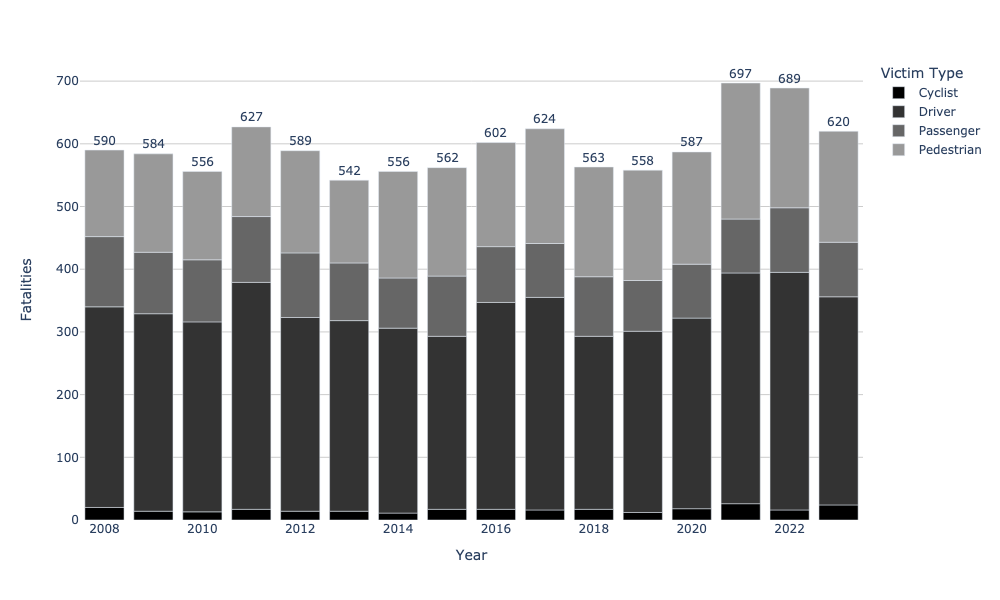

In [22]:
yt = year_types[[ 'cyclist', 'driver', 'passenger', 'pedestrian', ]]
yt.columns = [ f'{c[0].upper()}{c[1:]}' for c in yt.columns ]
yt_cols = yt.columns.tolist()
color_discrete_map = {
    col: '#' + (3 * str(3 * idx))
    for idx, col
    in enumerate(yt_cols)
}
# color_discrete_map = {
#     'Driver': '#000',
#     'Passenger': '#333',
#     'Pedestrian': '#666',
#     'Cyclist': '#999',
# }
fig = px.bar(
    yt,
    labels={
        'value': 'Fatalities',
        'year': 'Year',
        'variable': 'Victim Type',
    },
    color_discrete_map=color_discrete_map,
).update_layout(
    hovermode='x',
    plot_bgcolor='white',
).update_yaxes(
    gridcolor='#ccc',
).update_traces(
    hovertemplate=None,
)
for year, fatalities in year_types.fatalities.to_dict().items():
    fig.add_annotation(
        x=year, y=fatalities,
        text=fatalities,
        showarrow=False,
        yshift=10,
    )
# fig
Image(fig.to_image(width=1000, height=600))